Trial 5 Complete [00h 00m 45s]
val_loss: 0.00130611308850348

Best val_loss So Far: 0.0006746514118276536
Total elapsed time: 00h 04m 17s
Epoch 1/50


C:\Users\nixav\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - loss: 0.0085 - val_loss: 6.5109e-04
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - loss: 0.0012 - val_loss: 6.5613e-04
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - loss: 8.4016e-04 - val_loss: 0.0010
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 8.4282e-04 - val_loss: 5.3122e-04
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - loss: 8.8267e-04 - val_loss: 0.0010
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - loss: 7.9753e-04 - val_loss: 8.7043e-04
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - loss: 8.2397e-04 - val_loss: 0.0034
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - loss: 9.1289e-04 - val_loss: 0.0012
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 6.7521e-04 - val_loss: 9.5204e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


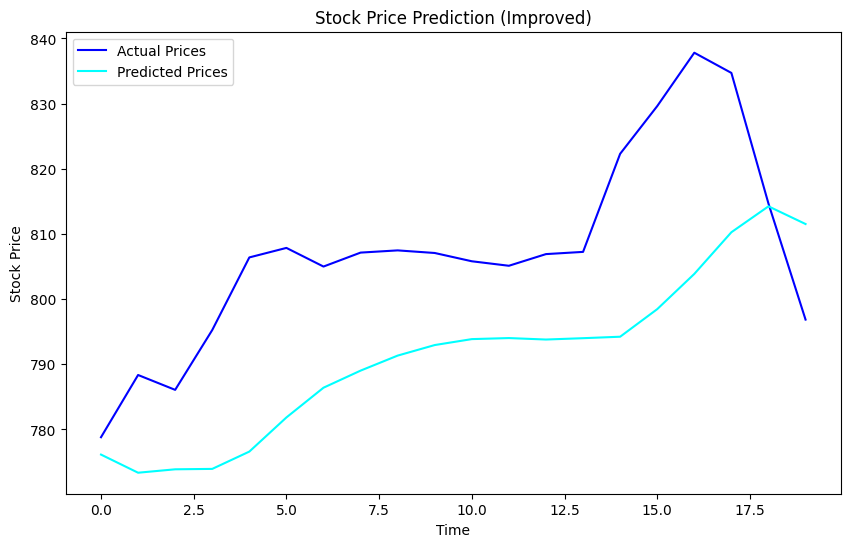

RMSE: 19.84, MAE: 17.80


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch

# Load Data
train_data = pd.read_csv("Google_Stock_Price_Train.csv")
test_data = pd.read_csv("Google_Stock_Price_Test.csv")

# Preprocess Data
sc = MinMaxScaler(feature_range=(0, 1))
train_scaled = sc.fit_transform(train_data.iloc[:, 1:2].values)
test_scaled = sc.transform(test_data.iloc[:, 1:2].values)

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Define Sequence Length
SEQUENCE_LENGTH = 60
X_train, y_train = create_sequences(train_scaled, SEQUENCE_LENGTH)
X_test, y_test = create_sequences(np.vstack((train_scaled[-SEQUENCE_LENGTH:], test_scaled)), SEQUENCE_LENGTH)

# Reshape Data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Hyperparameter Tuning using Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50),
                                 activation='tanh', return_sequences=True, 
                                 kernel_regularizer=l2(hp.Choice('l2', [0.01, 0.001, 0.0001]))), 
                                 input_shape=(SEQUENCE_LENGTH, 1)))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units_2', min_value=50, max_value=200, step=50), activation='tanh'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Hyperparameter Search
tuner = RandomSearch(build_model, objective='val_loss', max_trials=5, executions_per_trial=1, directory='tuner_dir', project_name='stock_lstm_tune')
tuner.search(X_train, y_train, validation_split=0.1, epochs=10, callbacks=[EarlyStopping(patience=5)])
best_model = tuner.get_best_models(num_models=1)[0]

# Train the Best Model
history = best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[EarlyStopping(patience=5)], verbose=1)

# Predict
predicted_stock_price = best_model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
actual_stock_price = sc.inverse_transform(y_test.reshape(-1, 1))

# Plot Predictions
plt.figure(figsize=(10, 6))
plt.plot(actual_stock_price, color='blue', label='Actual Prices')
plt.plot(predicted_stock_price, color='cyan', label='Predicted Prices')
plt.title('Stock Price Prediction (Improved)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Evaluate Model
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = np.sqrt(mean_squared_error(actual_stock_price, predicted_stock_price))
mae = mean_absolute_error(actual_stock_price, predicted_stock_price)
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")

